This is a tutorial for Python 2.7

# pyphysio library

## 2. Pipelines

In this tutorial we consider two pipelines for the processing of ECG and EDA signals respectively.

We divide the pipelines into three separate steps:
1. Filtering and Preprocessing: this step includes all the procedures aiming at increasing the signal/noise ratio, typycally band-pass filtering, smoothing, removal of artifacts. The output of this step is a new version of the imput signal with improved signal quality (less noise);
2. Information Extraction: this step aims at extracting the information of interest from the physiological signal. The output is a new signal containing only the information of interest and thus it has a **signal_nature** different from the input signal.
3. Physiological Indicators: this steps produces a list of scalar values able to describe the characteristics of the input signal. This step is usually performed on small segments of the input signals which are extracted using a sliding window on the whole length of the signal.

To understand how a signal processing step is represented in **pyphysio** see tutorial 1-signals_algorithms

In the following code we will also use the shortened sintax to apply a signal processing step:

```python
# standard sintax: creation + execution
filter_iir = ph.IIRFilter(fp=45, fs = 50, ftype='ellip') # creation of the processing step
ecg_out = filter_iir(ecg) # execution on the input signal


# shortened sintax: creation(execution)
ecg_out = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)```

However, the standard sintax is suggested when applying the same processing steps to multiple signals or for the clarity of the scripts:

Es:
```python
filter_iir = ph.IIRFilter(fp=45, fs = 50, ftype='ellip') # creation of the processing step

ecg_1_out = filter_iir(ecg_1) # execution on the input signal
ecg_2_out = filter_iir(ecg_2) # execution on the input signal
ecg_3_out = filter_iir(ecg_3) # execution on the input signal
```

### 2.1 ECG processing pipeline

** Step 0: Import data **

In [1]:
# import libraries
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
# import all pyphysio classes and methods
import pyphysio as ph

In [3]:
# import data and creating a signal

ecg_data = ph.TestData.ecg()

fsamp = 2048
ecg = ph.EvenlySignal(values = ecg_data, sampling_freq = fsamp, signal_nature = 'ecg')

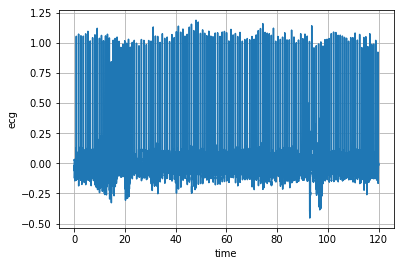

In [4]:
ecg.plot()

** Step 1: Filtering and preprocessing **

In [5]:
# (optional) IIR filtering : remove high frequency noise
ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

In [6]:
# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

In [7]:
# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096

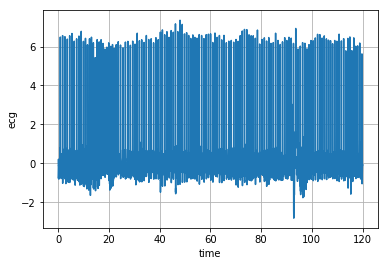

In [8]:
ecg.plot()

** Step 2: Information Extraction **

The information we want to extract from the ECG signal is the position of the heartbeats and the Inter Beat Interval signal.

In [9]:
ibi = ph.BeatFromECG()(ecg)

In [10]:
ibi.get_duration()

120.0

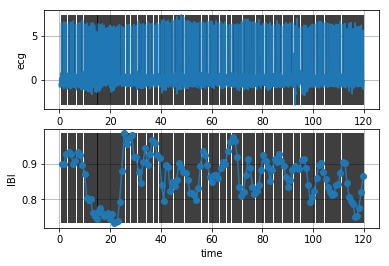

In [11]:
# check results so far
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

** Step 3: Physiological Indicators **

In [12]:
# create fake label
label = np.zeros(1200)
label[300:600] = 1
label[900:1200] = 2

label = ph.EvenlySignal(label, sampling_freq = 10, signal_nature = 'label')

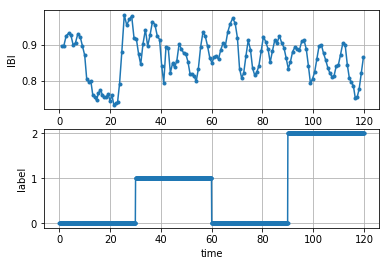

In [13]:
# check label
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()

In [14]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [15]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 5, width = 10, labels = label, drop_mixed=True, drop_cut=False)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [16]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]]
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]]

{'boxes': [<matplotlib.lines.Line2D at 0x7f7714a6ad10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7714a7ac50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7714a85f50>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f7714a85910>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f7714a6aed0>,
  <matplotlib.lines.Line2D at 0x7f7714a1d250>]}

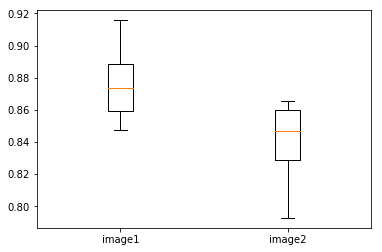

In [17]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['image1', 'image2'])

In [18]:
#label based windowing
label_based = ph.LabelSegments(labels = label)

#custom based windowing
custom_based = ph.CustomSegments(begins = [0, 30, 60, 90], 
                                 ends = [30, 60, 90, label.get_duration()], 
                                 labels=label)

`pyphysio` provides by default some presets of standard indicators for Heart Rate Variability and Electrodermal activity analysis.

Each indicator has its own pre-defined parameters:

In [19]:
HRV_FD = ph.preset_fd_hrv() #frequency domain HRV indicators
print(HRV_FD)

print(HRV_FD[0].get_params())

[IBI_VLF_Pow, IBI_LF_Pow, IBI_HF_Pow, IBI_Total_Pow]
{'name': 'IBI_VLF_Pow', 'freq_min': 1e-05, 'interp_freq': 4, 'method': 'ar', 'freq_max': 0.04}


If customization of the indicators is not needed, it is easier to directly use them instead of manually define each indicator:

In [20]:
FD_HRV_ind, col_names = ph.fmap(custom_based, ph.preset_fd_hrv(), ibi)

If needed to export the results, for instance in a .csv datafile, you can use `pandas`:

In [21]:
import pandas as pd

# create a pandas dataframe
FD_HRV_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_df

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,0,30,None,303.32,182.299,12.1775,499.777
1,30,60,None,82.038,208.61,188.107,508.079
2,60,90,None,73.9155,210.012,222.563,508.602
3,90,120,None,12.9978,420.191,75.8463,511.415


In [22]:
# and save it to a .csv file:

#FD_HRV_df.to_csv('filename.csv')

In [23]:
# BE CAREFUL when executing the above command (uncomment first) 
# as it will save a new file in your current working directory.
# To check your current working directory:
import os
print(os.getcwd())

/home/andrea/Trento/CODICE/workspaces/pyHRV/tutorials


### 2.2 EDA processing pipeline

** Step 0: Import data **

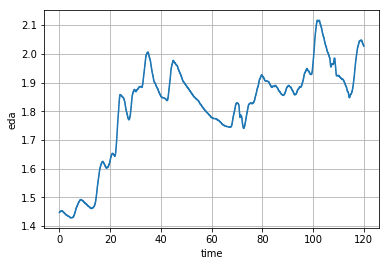

In [24]:
# import data and creating a signal

eda_data = ph.TestData.eda()

fsamp = 2048
eda = ph.EvenlySignal(values = eda_data, sampling_freq = fsamp, signal_nature = 'eda')

eda.plot()

** Step 1: Filtering and preprocessing **

In [25]:
# resampling : decrease the sampling frequency by cubic interpolation
eda = eda.resample(fout=8, kind='cubic')

In [26]:
# IIR filtering : remove high frequency noise
eda = ph.IIRFilter(fp=0.8, fs = 1.1, ftype='ellip')(eda)

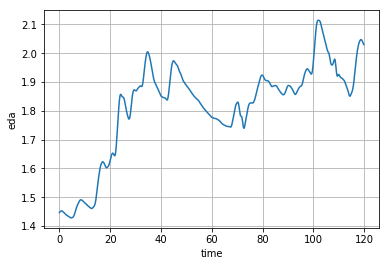

In [27]:
eda.plot()

** Step 2: Information Extraction **

The information we want to extract from the EDA signal is the phasic component associated to the sympathetic activity.

In [28]:
# estimate the driver function
driver = ph.DriverEstim()(eda)

>Creating empty EvenlySignal


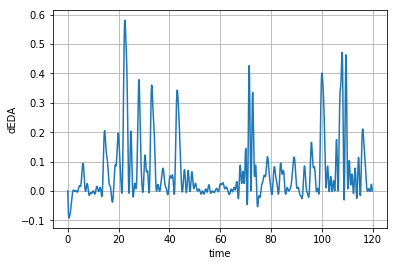

In [29]:
# compute the phasic component
phasic, tonic, _ = ph.PhasicEstim(delta=0.02)(driver)
phasic.plot()

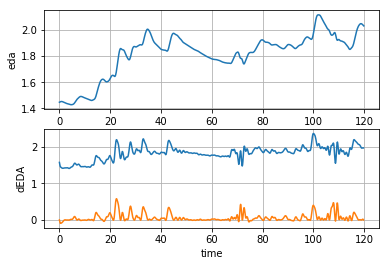

In [30]:
# check results so far
ax1 = plt.subplot(211)
eda.plot()

plt.subplot(212, sharex = ax1)
driver.plot()
phasic.plot()
plt.grid()
plt.show()

** Step 3: Physiological Indicators **

In [31]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 5, width = 20, labels = label)

# we use the preset indicators for the phasic signal.
# We need to define the minimum amplitude of the peaks that will be considered
PHA_ind, col_names = ph.fmap(fixed_length, ph.preset_phasic(delta=0.02), phasic)

>Creating empty EvenlySignal
>Creating empty EvenlySignal
>Creating empty EvenlySignal
>Creating empty EvenlySignal
>Creating empty EvenlySignal
>Creating empty EvenlySignal
>Warning: DurationMean: No peaks found
>Warning: SlopeMean: No peaks found
>Warning: DurationMean: No peaks found
>Warning: SlopeMean: No peaks found
>Creating empty EvenlySignal
>Creating empty EvenlySignal


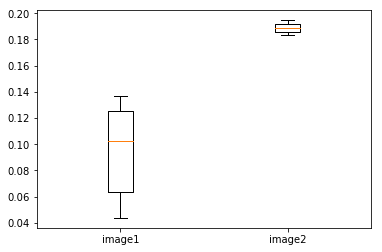

In [32]:
## Box-Whisker plot
## extract column with the labels for each window
label_w = PHA_ind[:, np.where(col_names == 'label')[0]]

## extract column with the PksMean values
## computed from each window
pksmean_w = PHA_ind[:, np.where(col_names == 'pha_PeaksMean')[0]]

pksmean_image1 = pksmean_w[np.where(label_w==1)[0]]
pksmean_image2 = pksmean_w[np.where(label_w==2)[0]]

## create a box and whisker plot 
## to compate the distibution of the RRmean indicator
plt.boxplot([pksmean_image1, pksmean_image2], 
            labels=['image1', 'image2'])
plt.show()